# 動作確認用のファイル

## 次のセルを実行して動くかどうか確認してください。
### 最低限のGPU環境があるかどうかを確認するためのものです。講義で使用する資料が動くことを保証するものではありません。

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:233: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

0/50000
10000/50000
20000/50000
30000/50000
40000/50000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:266: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
EPOCH: 0, Train [Loss: 1.451, Accuracy: 0.486], Valid [Loss: 1.090, Accuracy: 0.608]
EPOCH: 1, Train [Loss: 0.886, Accuracy: 0.687], Valid [Loss: 0.847, Accuracy: 0.698]
EPOCH: 2, Train [Loss: 0.702, Accuracy: 0.754], Valid [Loss: 0.778, Accuracy: 0.735]
EPOCH: 3, Train [Loss: 0.597, Accuracy: 0.793], Valid [Loss: 0.810, Accuracy: 0.725]
EPOCH: 4, Train [Loss: 0.510, Accuracy: 0.822], Valid [Loss: 0.816, Accuracy: 0.734]


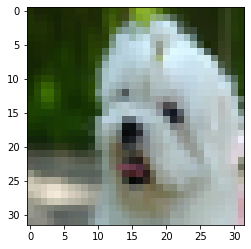

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 既存のGCNクラスは存在しないので、自作する.
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        E, V = torch.symeig(con_matrix, eigenvectors=True)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())
        #print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        #print(x)
        x = torch.mm(x, self.ZCA_matrix.t())
        #print(x)
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x    

class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期値
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/fan_in),
                        size=filter_shape
                    ).astype('float32')))

        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))

        self.function = function
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
        return self.function(u)

class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size()[0], -1)

class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
               
        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function

    def __call__(self, x):
        return self.function(x)
        
        
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


rng = np.random.RandomState(1234)
random_state = 42

batch_size = 1  # 可視化の際に扱いやすくするために1とする。

dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=False
)


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0),  # horizontally flipping
                                transforms.ToTensor()])

dataloader_train_flip = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

# fig = plt.figure(figsize=(9, 15))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
#                    wspace=0.05)

i = 0
for x, _ in dataloader_train_flip:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
#    ax.imshow(x)
    i += 1
    if i >= 81:
        break


transform = transforms.Compose([transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropoing
                                transforms.ToTensor()])

dataloader_train_crop = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

# fig = plt.figure(figsize=(9, 15))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
#                    wspace=0.05)

i = 0
for x, _ in dataloader_train_crop:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
#    ax.imshow(x)
    i += 1
    if i >= 81:
        break





GCN = gcn()
transform_GCN = transforms.Compose([transforms.ToTensor(),
                                    GCN])

dataloader_train_gcn = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_GCN),
    batch_size=batch_size,
    shuffle=False
)

# fig = plt.figure(figsize=(9, 15))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
#                    wspace=0.05)

i = 0
for x, _ in dataloader_train_gcn:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
#    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break








zca = ZCAWhitening()
images = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())
zca.fit(images)

transform_zca = transforms.Compose([transforms.ToTensor(),
                                    zca])

dataloader_train_zca = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_zca),
    batch_size=batch_size,
    shuffle=False
)

# fig = plt.figure(figsize=(9, 15))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
#                    wspace=0.05)

i = 0
for x, _ in dataloader_train_zca:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
#    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

conv_net = nn.Sequential(
    Conv((32, 3, 3, 3)),     # 32x32x3 -> 30x30x32
    BatchNorm((32, 30, 30)),
    Activation(F.relu),
    Pooling((2, 2)),                  # 30x30x32 -> 15x15x32
    Conv((64, 32, 3, 3)),     # 15x15x32 -> 13x13x64
    BatchNorm((64, 13, 13)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 13x13x64 -> 6x6x64
    Conv((128, 64, 3, 3)),           # 6x6x64 -> 4x4x128
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 4x4x128 -> 2x2x128
    Flatten(),
    Dense(2*2*128, 256, F.relu),
    Dense(256, 10)
)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)


trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

#zcaを定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),
                                zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000])

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)


for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))


trainval = datasets.CIFAR10('./data/cifar10')
image_id = 919  # 表示させる画像を選択
sample_image = trainval[image_id][0]
plt.imshow(sample_image)

print("最後の画像が表示されれば、10分以内に終われば最低限の演習環境として問題ないです。そうでない場合やもっと早く行いたいと思う方は、案内を参考に別の環境の用意をご検討ください。")
